In [1]:
import numpy as np
import pandas as pd
import os
import warnings
import librosa
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from random import shuffle
import scipy.stats as st

from pynwb import NWBHDF5IO
from pynwb.image import ImageSeries
from pynwb.epoch import TimeIntervals

In [2]:
nwbpath = 'C:\\Users\\nhogl\\Documents\\GitHub\\scn2a-paper-GWJSNH-code\\NWB'

assay = 'reunion'
allnwb = []
allnwb += [os.path.join(nwbpath,each) for each in os.listdir(nwbpath) if assay in each]

usefield = 'single_behavior_Huddle'

In [4]:
test = [allnwb[0]]
for i,fname in enumerate(test):
    # open file
    io = NWBHDF5IO(os.path.join(nwbpath,fname), mode="r") # <-- open in write to append snippets?
    nwbfile = io.read()

In [6]:
# nwbfile
usefield = 'single_behavior_Huddle'
statsdf = nwbfile.intervals[usefield].to_dataframe()

In [11]:
statsdf

,start_time,stop_time,behavior,duration,atype
id,,,,,
22,13.656,15.404,Huddle,1.748,STATE
35,21.906,26.905,Huddle,4.999,STATE
38,27.904,30.404,Huddle,2.500,STATE
43,35.906,63.154,Huddle,27.248,STATE
57,77.149,77.417,Huddle,0.268,STATE
...,...,...,...,...,...
466,1673.151,1674.650,Huddle,1.499,STATE
472,1705.988,1708.736,Huddle,2.748,STATE
475,1729.487,1731.486,Huddle,1.999,STATE


In [12]:
# ---- Look at latency to mount in timed matings ----

# keep track of details in arrays
allGT = []
allSex = []
times = []
colors = []
nroccurrences = []
# behav='Mount'

# loop over nwb files matching specified assay name
for i,fname in enumerate(allnwb):
    # open file
    io = NWBHDF5IO(os.path.join(nwbpath,fname), mode="r") # <-- open in write to append snippets?
    nwbfile = io.read()
    
    # for sanity check, print out the name of the file being handled
    pathsplit = fname.split('\\')
    recstem = pathsplit[-1].strip('.nwb')
    print(recstem)
    
    # filter out files that don't have complete timelines
    
    # keep track of metadata
    allSex.append(nwbfile.subject.sex)
    allGT.append(nwbfile.subject.genotype)
    colors.append(nwbfile.lab_meta_data['vole_metadata'].colors[:])
       
    # -- Get time of first behavior --
    
    # load up the BORIS table from the NWB file
    statsdf = nwbfile.intervals[usefield].to_dataframe()
    
    # find start time of assay
#     assayStart = float(statsdf.start_time[statsdf.behavior=='Start assay'])
    # find time of first scored mount
    firstBehav = np.min(statsdf.start_time)
    # subtract start time to get assay-aligned time
#     firstMountAligned = firstMount-assayStart
    # append to times array
    times.append(firstBehav)
    # count total number of mounts
    nroccurrences.append(statsdf.shape[0])

Nov22_Pair15_reunio
Nov22_Pair16_reunio
Nov22_Pair17_reunio
Nov22_Pair18_reunio
Nov22_Pair19_reunio
Nov22_Pair1_reunio
Nov22_Pair21_reunio
Nov22_Pair22_reunio
Nov22_Pair23_reunio
Nov22_Pair24_reunio
Nov22_Pair25_reunio
Nov22_Pair26_reunio
Nov22_Pair27_reunio
Nov22_Pair28_reunio
Nov22_Pair29_reunio
Nov22_Pair2_reunio
Nov22_Pair30_reunio
Nov22_Pair31_reunio
Nov22_Pair32_reunio
Nov22_Pair33_reunio
Nov22_Pair34_reunio
Nov22_Pair35_reunio
Nov22_Pair36_reunio
Nov22_Pair37_reunio
Nov22_Pair38_reunio
Nov22_Pair39_reunio
Nov22_Pair3_reunio
Nov22_Pair40_reunio
Nov22_Pair41_reunio
Nov22_Pair43_reunio
Nov22_Pair44_reunio
Nov22_Pair46_reunio
Nov22_Pair47_reunio
Nov22_Pair48_reunio
Nov22_Pair49_reunio
Nov22_Pair4_reunio
Nov22_Pair50_reunio
Nov22_Pair51_reunio
Nov22_Pair52_reunio
Nov22_Pair56_reunio
Nov22_Pair57_reunio
Nov22_Pair58_reunio
Nov22_Pair59_reunio
Nov22_Pair5_reunio
Nov22_Pair60_reunio
Nov22_Pair61_reunio
Nov22_Pair62_reunio
Nov22_Pair64_reunio
Nov22_Pair6_reunio
Nov22_Pair7_reunio
Nov22_P

In [20]:
# --- Make table of latency data ---
ld = {'genotype': allGT, 'sex': allSex, 'number':nroccurrences,'latencies': times, 'colors': colors}
ldf = pd.DataFrame(data=ld) # store in dataframe
ldf["joint_category"] = ldf['sex'].add(ldf['genotype']) # add a column that maps the GT/sex 2x2 into 4 groups

reunion_huddle_ldf = ldf

In [14]:
# --- Make color palettes ---
col1 = ldf.colors[np.logical_and(ldf.genotype=='WT',ldf.sex=='F')].reset_index(drop=True)[0]/255
col2 = ldf.colors[np.logical_and(ldf.genotype=='Het',ldf.sex=='F')].reset_index(drop=True)[0]/255
col3 = ldf.colors[np.logical_and(ldf.genotype=='WT',ldf.sex=='M')].reset_index(drop=True)[0]/255
col4 = ldf.colors[np.logical_and(ldf.genotype=='Het',ldf.sex=='M')].reset_index(drop=True)[0]/255
fcols = [col1,col2]
mcols = [col3,col4] # match colors to groups
fpal = sns.color_palette(fcols)
mpal = sns.color_palette(mcols)

In [15]:
def strip_plots_with_medians(datatab,sex,plotvar,huevar,sz,alpha,edgecolor,ptborder,palette,hueorder,mw,zorder,ylabel,ax,f):
    
    spec = dict(x=huevar, y=plotvar, data=datatab[datatab.sex==sex],hue=huevar)
    
    sns.stripplot(**spec,s=sz,
                  alpha=alpha,
                  legend=False,
                  ax=ax,
                  edgecolor=edgecolor,
                  linewidth=ptborder,
                  palette=palette,
                  hue_order=hue_order,
                  order=hue_order)

    medtab = datatab[datatab.sex==sex].groupby(huevar, sort=False)[plotvar].median().reindex(hueorder)
    _ = [ax.hlines(y, i-mw, i+mw, zorder=zorder,colors=[0,0,0],linewidths=lw) for i, y in medtab.reset_index()[plotvar].items()]

    # make axes look nice
    ax.set(xlabel="")
    ax.set(ylabel=ylabel)
    sns.despine(fig=f, ax=ax, top=True, right=True, left=False, bottom=True, offset=None, trim=False)
    ax.tick_params(axis='x',length=0)

Power_divergenceResult(statistic=array([0.002779, 0.      ]), pvalue=array([0.95795802, 1.        ]))
MannwhitneyuResult(statistic=71.0, pvalue=0.7236736098317631)
MannwhitneyuResult(statistic=65.0, pvalue=0.3405049231171826)
MannwhitneyuResult(statistic=97.0, pvalue=0.31428698551892353)
MannwhitneyuResult(statistic=77.0, pvalue=0.7381351386116883)


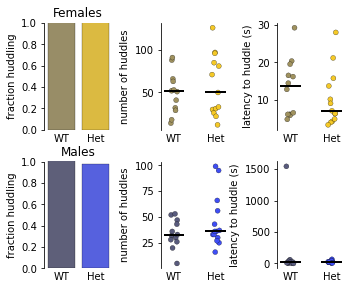

In [19]:
# --- All plots in subplots ---

# set parameters
sz=5 # dot size for strip plots
alpha=1 # dot transparency for strip plots
medianwidth=0.5 # width on x axis of median bands
mw = medianwidth/2 # convert to halfwidth for plotting
lw = 2 # weight of median band lines
hue_order = ['WT','Het'] # how groups should be arranged on x axis
figp=os.path.join('figures','2024June') # where to save figures
csz = 0.25
ptc='k'
plw=0.25
zorder=5
nrows = 2
ncols = 3

saveplots = False # whether to write plot outputs to disk


# make figure and subplots
f, ax = plt.subplots(nrows,ncols,figsize=(5, 4))
f.tight_layout()

# FRACTION MOUNTING

nrmountingF = ldf[ldf.sex=='F'].groupby('genotype', as_index=False).count()
nrmountingF['fraction']=nrmountingF.latencies/nrmountingF.number
nrmountingM = ldf[ldf.sex=='M'].groupby('genotype', as_index=False).count()
nrmountingM['fraction']=nrmountingM.latencies/nrmountingM.number

# stats
chisq = st.chisquare((nrmountingF.fraction,nrmountingM.fraction))
print(chisq)

# plot
sns.barplot(data=nrmountingF,x='genotype',y='fraction',ax=ax[0][0],palette=fpal,
            hue_order=hue_order,order=hue_order,edgecolor=ptc,linewidth=plw)
ax[0][0].set(xlabel="")
ax[0][0].set(ylabel='fraction huddling')
ax[0][0].set_ylim(top=1)
ax[0][0].set_title('Females')
sns.despine(fig=f, ax=ax[0][0], top=True, right=True, left=False, bottom=False, offset=None, trim=False)
ax[0][0].tick_params(axis='x',length=0)

sns.barplot(data=nrmountingM,x='genotype',y='fraction',ax=ax[1][0],palette=mpal,
            hue_order=hue_order,order=hue_order,edgecolor=ptc,linewidth=plw)
ax[1][0].set(xlabel="")
ax[1][0].set(ylabel='fraction huddling')
ax[1][0].set_ylim(top=1)
sns.despine(fig=f, ax=ax[1][0], top=True, right=True, left=False, bottom=False, offset=None, trim=False)
ax[1][0].tick_params(axis='x',length=0)
ax[1][0].set_title('Males')


# NUMBER OF MOUNTS

# stats
nroccstats_F = st.mannwhitneyu(ldf.number[np.logical_and(ldf.sex=='F',ldf.genotype=='WT')],ldf.number[np.logical_and(ldf.sex=='F',ldf.genotype=='Het')])
print(nroccstats_F)
nroccstats_M = st.mannwhitneyu(ldf.number[np.logical_and(ldf.sex=='M',ldf.genotype=='WT')],ldf.number[np.logical_and(ldf.sex=='M',ldf.genotype=='Het')])
print(nroccstats_M)

# plot
strip_plots_with_medians(ldf,'F','number','genotype',sz,alpha,ptc,plw,fpal,hue_order,mw,zorder,'number of huddles',ax[0][1],f)
strip_plots_with_medians(ldf,'M','number','genotype',sz,alpha,ptc,plw,mpal,hue_order,mw,zorder,'number of huddles',ax[1][1],f)


# LATENCY TO MOUNT

# stats
latencystats_F = st.mannwhitneyu(ldf.latencies[np.logical_and(ldf.sex=='F',ldf.genotype=='WT')].dropna(),ldf.latencies[np.logical_and(ldf.sex=='F',ldf.genotype=='Het')].dropna())
print(latencystats_F)
latencystats_M = st.mannwhitneyu(ldf.latencies[np.logical_and(ldf.sex=='M',ldf.genotype=='WT')].dropna(),ldf.latencies[np.logical_and(ldf.sex=='M',ldf.genotype=='Het')].dropna())
print(latencystats_M)

# plot

strip_plots_with_medians(ldf,'F','latencies','genotype',sz,alpha,ptc,plw,fpal,hue_order,mw,zorder,'latency to huddle (s)',ax[0][2],f)
strip_plots_with_medians(ldf,'M','latencies','genotype',sz,alpha,ptc,plw,mpal,hue_order,mw,zorder,'latency to huddle (s)',ax[1][2],f)

if saveplots:
    plt.savefig(os.path.join(figp,'timedMating_latency-to-huddle_all-data.pdf'))

In [24]:
# latency to partner huddle in PPT
assay = 'PPT'
allnwb = []
allnwb += [os.path.join(nwbpath,each) for each in os.listdir(nwbpath) if assay in each]

usefield = 'single_behavior_Huddle Partner'

# ---- Look at latency to huddle with partner in PPTs ----

# keep track of details in arrays
allGT = []
allSex = []
times = []
colors = []
nroccurrences = []
# behav='Mount'

# loop over nwb files matching specified assay name
for i,fname in enumerate(allnwb):
    # open file
    io = NWBHDF5IO(os.path.join(nwbpath,fname), mode="r") # <-- open in write to append snippets?
    nwbfile = io.read()
    
    # for sanity check, print out the name of the file being handled
    pathsplit = fname.split('\\')
    recstem = pathsplit[-1].strip('.nwb')
    print(recstem)
    
    # filter out files that don't have complete timelines
    
    # keep track of metadata
    allSex.append(nwbfile.subject.sex)
    allGT.append(nwbfile.subject.genotype)
    colors.append(nwbfile.lab_meta_data['vole_metadata'].colors[:])
       
    # -- Get time of first behavior --
    
    # load up the BORIS table from the NWB file
    try:
        statsdf = nwbfile.intervals[usefield].to_dataframe()
        # find time of first scored behavior
        firstBehav = np.min(statsdf.start_time)
        # append to times array
        times.append(firstBehav)
        # count total number of mounts
        nroccurrences.append(statsdf.shape[0])
    except:
        nroccurrences.append(0)
        times.append(np.NaN)
    
# --- Make table of latency data ---
ld = {'genotype': allGT, 'sex': allSex, 'number':nroccurrences,'latencies': times, 'colors': colors}
ldf = pd.DataFrame(data=ld) # store in dataframe
ldf["joint_category"] = ldf['sex'].add(ldf['genotype']) # add a column that maps the GT/sex 2x2 into 4 groups

PPT_partner_huddle_ldf = ldf

Nov22_Pair15_PPT
Nov22_Pair16_PPT
Nov22_Pair17_PPT
Nov22_Pair18_PPT
Nov22_Pair19_PPT
Nov22_Pair1_PPT
Nov22_Pair21_PPT
Nov22_Pair22_PPT
Nov22_Pair23_PPT
Nov22_Pair24_PPT
Nov22_Pair25_PPT
Nov22_Pair26_PPT
Nov22_Pair27_PPT
Nov22_Pair28_PPT
Nov22_Pair29_PPT
Nov22_Pair2_PPT
Nov22_Pair30_PPT
Nov22_Pair31_PPT
Nov22_Pair32_PPT
Nov22_Pair33_PPT
Nov22_Pair34_PPT
Nov22_Pair35_PPT
Nov22_Pair36_PPT
Nov22_Pair37_PPT
Nov22_Pair38_PPT
Nov22_Pair3_PPT
Nov22_Pair40_PPT
Nov22_Pair41_PPT
Nov22_Pair42_PPT
Nov22_Pair43_PPT
Nov22_Pair44_PPT
Nov22_Pair46_PPT
Nov22_Pair47_PPT
Nov22_Pair48_PPT
Nov22_Pair49_PPT
Nov22_Pair4_PPT
Nov22_Pair50_PPT
Nov22_Pair51_PPT
Nov22_Pair52_PPT
Nov22_Pair56_PPT
Nov22_Pair57_PPT
Nov22_Pair58_PPT
Nov22_Pair59_PPT
Nov22_Pair5_PPT
Nov22_Pair61_PPT
Nov22_Pair62_PPT
Nov22_Pair63_PPT
Nov22_Pair64_PPT
Nov22_Pair6_PPT
Nov22_Pair7_PPT
Nov22_Pair8_PPT


Power_divergenceResult(statistic=array([0.00307692, 0.        ]), pvalue=array([0.95576401, 1.        ]))
MannwhitneyuResult(statistic=71.5, pvalue=0.7438689348376387)
MannwhitneyuResult(statistic=62.5, pvalue=0.31101802177702276)
MannwhitneyuResult(statistic=73.0, pvalue=0.9769702553219757)
MannwhitneyuResult(statistic=99.0, pvalue=0.40631330215979156)


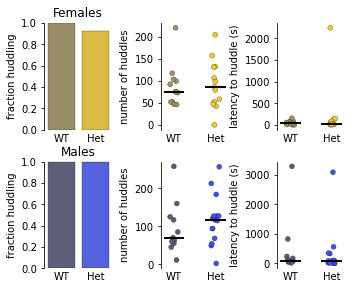

In [29]:
# --- All plots in subplots ---

# set parameters
sz=5 # dot size for strip plots
alpha=1 # dot transparency for strip plots
medianwidth=0.5 # width on x axis of median bands
mw = medianwidth/2 # convert to halfwidth for plotting
lw = 2 # weight of median band lines
hue_order = ['WT','Het'] # how groups should be arranged on x axis
figp=os.path.join('figures','2024June') # where to save figures
csz = 0.25
ptc='k'
plw=0.25
zorder=5
nrows = 2
ncols = 3

saveplots = False # whether to write plot outputs to disk


# make figure and subplots
f, ax = plt.subplots(nrows,ncols,figsize=(5, 4))
f.tight_layout()

# FRACTION MOUNTING

nrmountingF = ldf[ldf.sex=='F'].groupby('genotype', as_index=False).count()
nrmountingF['fraction']=nrmountingF.latencies/nrmountingF.number
nrmountingM = ldf[ldf.sex=='M'].groupby('genotype', as_index=False).count()
nrmountingM['fraction']=nrmountingM.latencies/nrmountingM.number

# stats
chisq = st.chisquare((nrmountingF.fraction,nrmountingM.fraction))
print(chisq)

# plot
sns.barplot(data=nrmountingF,x='genotype',y='fraction',ax=ax[0][0],palette=fpal,
            hue_order=hue_order,order=hue_order,edgecolor=ptc,linewidth=plw)
ax[0][0].set(xlabel="")
ax[0][0].set(ylabel='fraction huddling')
ax[0][0].set_ylim(top=1)
ax[0][0].set_title('Females')
sns.despine(fig=f, ax=ax[0][0], top=True, right=True, left=False, bottom=False, offset=None, trim=False)
ax[0][0].tick_params(axis='x',length=0)

sns.barplot(data=nrmountingM,x='genotype',y='fraction',ax=ax[1][0],palette=mpal,
            hue_order=hue_order,order=hue_order,edgecolor=ptc,linewidth=plw)
ax[1][0].set(xlabel="")
ax[1][0].set(ylabel='fraction huddling')
ax[1][0].set_ylim(top=1)
sns.despine(fig=f, ax=ax[1][0], top=True, right=True, left=False, bottom=False, offset=None, trim=False)
ax[1][0].tick_params(axis='x',length=0)
ax[1][0].set_title('Males')


# NUMBER OF MOUNTS

# stats
nroccstats_F = st.mannwhitneyu(ldf.number[np.logical_and(ldf.sex=='F',ldf.genotype=='WT')],ldf.number[np.logical_and(ldf.sex=='F',ldf.genotype=='Het')])
print(nroccstats_F)
nroccstats_M = st.mannwhitneyu(ldf.number[np.logical_and(ldf.sex=='M',ldf.genotype=='WT')],ldf.number[np.logical_and(ldf.sex=='M',ldf.genotype=='Het')])
print(nroccstats_M)

# plot
strip_plots_with_medians(ldf,'F','number','genotype',sz,alpha,ptc,plw,fpal,hue_order,mw,zorder,'number of huddles',ax[0][1],f)
strip_plots_with_medians(ldf,'M','number','genotype',sz,alpha,ptc,plw,mpal,hue_order,mw,zorder,'number of huddles',ax[1][1],f)


# LATENCY TO MOUNT

# stats
latencystats_F = st.mannwhitneyu(ldf.latencies[np.logical_and(ldf.sex=='F',ldf.genotype=='WT')].dropna(),ldf.latencies[np.logical_and(ldf.sex=='F',ldf.genotype=='Het')].dropna())
print(latencystats_F)
latencystats_M = st.mannwhitneyu(ldf.latencies[np.logical_and(ldf.sex=='M',ldf.genotype=='WT')].dropna(),ldf.latencies[np.logical_and(ldf.sex=='M',ldf.genotype=='Het')].dropna())
print(latencystats_M)

# plot

strip_plots_with_medians(ldf,'F','latencies','genotype',sz,alpha,ptc,plw,fpal,hue_order,mw,zorder,'latency to huddle (s)',ax[0][2],f)
strip_plots_with_medians(ldf,'M','latencies','genotype',sz,alpha,ptc,plw,mpal,hue_order,mw,zorder,'latency to huddle (s)',ax[1][2],f)

if saveplots:
    plt.savefig(os.path.join(figp,'timedMating_latency-to-huddle_all-data.pdf'))

In [31]:
nrmountingF

,genotype,sex,number,latencies,colors,joint_category,fraction
0,Het,13,13,12,13,13,0.923077
1,WT,12,12,12,12,12,1.000000
